# 🌟 Objective 3: Feature Engineering & Star Power Index
## MCM Problem C 2026

**Goal:** Create a comprehensive feature set for analyzing pro dancer and celebrity characteristics.

### Key Features to Engineer:
1. **Celebrity Features:** Age brackets, industry clusters, geographic regions
2. **Pro Dancer Features:** Experience, historical win rate, style specialties
3. **Star Power Index (SPI):** Wikipedia page views, social media following estimates
4. **Performance Trajectory:** Week-over-week improvement metrics

---

## 1. Setup & Data Loading

In [20]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_PATH = Path('../../data')
OUTPUT_PATH = DATA_PATH / 'obj3'
OUTPUT_PATH.mkdir(exist_ok=True)

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load main dataset
df = pd.read_csv(DATA_PATH / '2026_MCM_Problem_C_Data.csv', na_values=['N/A', 'n/a', ''])

# Load fan vote estimates from Objective 1
fan_votes_df = pd.read_csv(DATA_PATH / 'obj1' / 'fan_vote_estimates.csv')

print(f"Main dataset: {df.shape[0]} contestants across {df['season'].nunique()} seasons")
print(f"Fan vote estimates: {fan_votes_df.shape[0]} records")
print(f"\nColumns: {list(df.columns[:10])}...")

Main dataset: 421 contestants across 34 seasons
Fan vote estimates: 2067 records

Columns: ['celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region', 'celebrity_age_during_season', 'season', 'results', 'placement', 'week1_judge1_score']...


In [3]:
# Quick overview
print("\n📊 DATA OVERVIEW")
print("="*60)
print(f"Unique celebrities: {df['celebrity_name'].nunique()}")
print(f"Unique pro dancers: {df['ballroom_partner'].nunique()}")
print(f"Industries: {df['celebrity_industry'].nunique()}")
print(f"\nIndustry distribution:")
print(df['celebrity_industry'].value_counts().head(10))


📊 DATA OVERVIEW
Unique celebrities: 408
Unique pro dancers: 60
Industries: 26

Industry distribution:
celebrity_industry
Actor/Actress               128
Athlete                      95
TV Personality               67
Singer/Rapper                61
Model                        17
Comedian                     12
Social Media Personality      8
Racing Driver                 4
Radio Personality             4
Entrepreneur                  4
Name: count, dtype: int64


---

## 2. Celebrity Feature Engineering

In [4]:
# Create age brackets
def create_age_bracket(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 25:
        return 'Young (18-24)'
    elif age < 35:
        return 'Prime (25-34)'
    elif age < 45:
        return 'Mid (35-44)'
    elif age < 55:
        return 'Mature (45-54)'
    else:
        return 'Senior (55+)'

df['age_bracket'] = df['celebrity_age_during_season'].apply(create_age_bracket)

print("Age bracket distribution:")
print(df['age_bracket'].value_counts())

Age bracket distribution:
age_bracket
Prime (25-34)     130
Mid (35-44)       109
Mature (45-54)     69
Young (18-24)      57
Senior (55+)       56
Name: count, dtype: int64


In [5]:
# Create industry clusters (group similar industries)
INDUSTRY_CLUSTERS = {
    'Entertainment': ['Actor/Actress', 'Singer/Rapper', 'Comedian', 'TV Personality'],
    'Sports': ['Athlete', 'Racing Driver', 'Sports Broadcaster'],
    'Media': ['News Anchor', 'Social media personality', 'Model'],
    'Other': ['Beauty Pageant', 'Conservationist', 'Con artist', 'Entrepreneur']
}

def get_industry_cluster(industry):
    if pd.isna(industry):
        return 'Unknown'
    for cluster, industries in INDUSTRY_CLUSTERS.items():
        if industry in industries:
            return cluster
    return 'Other'

df['industry_cluster'] = df['celebrity_industry'].apply(get_industry_cluster)

print("Industry cluster distribution:")
print(df['industry_cluster'].value_counts())

Industry cluster distribution:
industry_cluster
Entertainment    268
Sports           101
Other             31
Media             21
Name: count, dtype: int64


In [6]:
# Create geographic regions
US_REGIONS = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 
                  'Connecticut', 'New York', 'New Jersey', 'Pennsylvania'],
    'Southeast': ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 
                  'North Carolina', 'South Carolina', 'Tennessee', 'Georgia', 'Florida', 
                  'Alabama', 'Mississippi', 'Arkansas', 'Louisiana'],
    'Midwest': ['Ohio', 'Indiana', 'Michigan', 'Illinois', 'Wisconsin', 'Minnesota', 
                'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
    'Southwest': ['Texas', 'Oklahoma', 'New Mexico', 'Arizona'],
    'West': ['Colorado', 'Wyoming', 'Montana', 'Idaho', 'Washington', 'Oregon', 
             'Utah', 'Nevada', 'California', 'Alaska', 'Hawaii']
}

def get_region(state, country):
    if pd.isna(country) or country != 'United States':
        return 'International'
    if pd.isna(state):
        return 'US-Unknown'
    for region, states in US_REGIONS.items():
        if state in states:
            return region
    return 'US-Other'

df['region'] = df.apply(lambda x: get_region(x['celebrity_homestate'], 
                                              x['celebrity_homecountry/region']), axis=1)

print("Region distribution:")
print(df['region'].value_counts())

Region distribution:
region
West             94
Southeast        90
Northeast        84
Midwest          62
International    56
Southwest        30
US-Other          5
Name: count, dtype: int64


---

## 3. Pro Dancer Feature Engineering

In [7]:
# Calculate pro dancer statistics
pro_stats = df.groupby('ballroom_partner').agg({
    'season': ['count', 'min', 'max'],
    'placement': ['mean', 'min'],
    'celebrity_name': 'count'
}).reset_index()

pro_stats.columns = ['pro_dancer', 'seasons_count', 'first_season', 'last_season', 
                     'avg_placement', 'best_placement', 'partners_count']

# Calculate win rate (1st place = win)
wins = df[df['placement'] == 1].groupby('ballroom_partner').size().reset_index(name='wins')
pro_stats = pro_stats.merge(wins, left_on='pro_dancer', right_on='ballroom_partner', how='left')
pro_stats['wins'] = pro_stats['wins'].fillna(0).astype(int)
pro_stats['win_rate'] = pro_stats['wins'] / pro_stats['seasons_count']

# Top 3 rate
top3 = df[df['placement'] <= 3].groupby('ballroom_partner').size().reset_index(name='top3_finishes')
pro_stats = pro_stats.merge(top3, left_on='pro_dancer', right_on='ballroom_partner', how='left')
pro_stats['top3_finishes'] = pro_stats['top3_finishes'].fillna(0).astype(int)
pro_stats['top3_rate'] = pro_stats['top3_finishes'] / pro_stats['seasons_count']

# Clean up
pro_stats = pro_stats.drop(columns=['ballroom_partner_x', 'ballroom_partner_y'], errors='ignore')

print("\n🏆 TOP PRO DANCERS BY WIN RATE (min 3 seasons):")
print(pro_stats[pro_stats['seasons_count'] >= 3].nlargest(10, 'win_rate')[[
    'pro_dancer', 'seasons_count', 'wins', 'win_rate', 'top3_rate', 'avg_placement'
]].to_string(index=False))


🏆 TOP PRO DANCERS BY WIN RATE (min 3 seasons):
           pro_dancer  seasons_count  wins  win_rate  top3_rate  avg_placement
       Julianne Hough              5     2  0.400000   0.400000       4.200000
          Derek Hough             17     6  0.352941   0.529412       2.941176
        Jenna Johnson              9     2  0.222222   0.444444       6.444444
            Alec Mazo              5     1  0.200000   0.200000       8.400000
    Daniella Karagach              5     1  0.200000   0.600000       4.600000
Valentin Chmerkovskiy             19     3  0.157895   0.473684       5.263158
          Kym Johnson             14     2  0.142857   0.285714       6.285714
          Mark Ballas             21     3  0.142857   0.476190       5.190476
      Peta Murgatroyd             15     2  0.133333   0.133333       7.400000
         Alan Bersten              9     1  0.111111   0.222222       6.111111


In [8]:
# Merge pro dancer features back to main dataframe
df = df.merge(pro_stats[['pro_dancer', 'seasons_count', 'win_rate', 'top3_rate', 
                         'avg_placement', 'first_season']], 
              left_on='ballroom_partner', right_on='pro_dancer', how='left')

# Pro experience at time of season (seasons they've done before this one)
df['pro_experience'] = df['season'] - df['first_season']
df['pro_experience'] = df['pro_experience'].clip(lower=0)  # Can't be negative

print("\nPro experience distribution:")
print(df['pro_experience'].describe())


Pro experience distribution:
count    421.000000
mean       7.197150
std        6.269472
min        0.000000
25%        2.000000
50%        6.000000
75%       11.000000
max       30.000000
Name: pro_experience, dtype: float64


---

## 4. Star Power Index (SPI) via Wikipedia API

We'll estimate celebrity fame using Wikipedia page view statistics as a proxy for public interest/recognition.

In [9]:
import requests
import time
from urllib.parse import quote

def get_wikipedia_pageviews(celebrity_name, year=2024, month=12):
    """
    Get Wikipedia page views for a celebrity.
    Uses the Wikimedia REST API for pageview statistics.
    
    Returns average daily page views for the specified month.
    """
    # Format name for Wikipedia URL (replace spaces with underscores)
    wiki_name = celebrity_name.replace(' ', '_')
    wiki_name = quote(wiki_name, safe='_')
    
    # Wikimedia Pageviews API
    # Get views for Dec 2024 (recent baseline)
    start_date = f"{year}{month:02d}01"
    end_date = f"{year}{month:02d}28"
    
    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{wiki_name}/daily/{start_date}/{end_date}"
    
    headers = {
        'User-Agent': 'MCM_Problem_C_Analysis/1.0 (Academic Research)'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()
            views = [item['views'] for item in data.get('items', [])]
            if views:
                return np.mean(views)
        return None
    except Exception as e:
        return None

# Test with a known celebrity
test_celeb = "Kelly Monaco"
test_views = get_wikipedia_pageviews(test_celeb)
print(f"Test: {test_celeb} → {test_views:.0f} avg daily views" if test_views else f"Test: {test_celeb} → No data")

Test: Kelly Monaco → 529 avg daily views


In [10]:
# Fetch Wikipedia pageviews for all celebrities (with rate limiting)
print("Fetching Wikipedia pageviews for all celebrities...")
print("(This may take a few minutes due to rate limiting)\n")

unique_celebrities = df['celebrity_name'].unique()
wiki_views = {}

for i, celeb in enumerate(unique_celebrities):
    views = get_wikipedia_pageviews(celeb)
    wiki_views[celeb] = views
    
    # Progress indicator every 50 celebrities
    if (i + 1) % 50 == 0:
        found = sum(1 for v in wiki_views.values() if v is not None)
        print(f"  Progress: {i+1}/{len(unique_celebrities)} ({found} found)")
    
    # Rate limiting: 100 requests per second is the limit, we'll be conservative
    time.sleep(0.05)

# Summary
found_count = sum(1 for v in wiki_views.values() if v is not None)
print(f"\n✓ Fetched pageviews for {found_count}/{len(unique_celebrities)} celebrities")

Fetching Wikipedia pageviews for all celebrities...
(This may take a few minutes due to rate limiting)

  Progress: 50/408 (49 found)
  Progress: 100/408 (98 found)
  Progress: 150/408 (111 found)
  Progress: 200/408 (123 found)
  Progress: 250/408 (135 found)
  Progress: 300/408 (148 found)
  Progress: 350/408 (159 found)
  Progress: 400/408 (172 found)

✓ Fetched pageviews for 174/408 celebrities


In [11]:
# Add Wikipedia views to dataframe
df['wiki_pageviews'] = df['celebrity_name'].map(wiki_views)

# Handle missing values with industry-based imputation
# Impute missing with industry median
industry_medians = df.groupby('celebrity_industry')['wiki_pageviews'].median()
df['wiki_pageviews_imputed'] = df.apply(
    lambda x: x['wiki_pageviews'] if pd.notna(x['wiki_pageviews']) 
              else industry_medians.get(x['celebrity_industry'], df['wiki_pageviews'].median()),
    axis=1
)

# Create Star Power Index (normalized 0-100)
df['star_power_index'] = 100 * (df['wiki_pageviews_imputed'] - df['wiki_pageviews_imputed'].min()) / \
                         (df['wiki_pageviews_imputed'].max() - df['wiki_pageviews_imputed'].min())

print("Star Power Index distribution:")
print(df['star_power_index'].describe())

Star Power Index distribution:
count    414.000000
mean       8.398145
std        8.372346
min        0.000000
25%        3.157047
50%        7.101685
75%        9.632781
max      100.000000
Name: star_power_index, dtype: float64


In [12]:
# Top celebrities by Star Power Index
print("\n⭐ TOP 20 CELEBRITIES BY STAR POWER INDEX:")
print("="*70)
top_spi = df.nlargest(20, 'star_power_index')[[
    'celebrity_name', 'season', 'celebrity_industry', 'star_power_index', 'placement'
]].copy()
top_spi['star_power_index'] = top_spi['star_power_index'].round(1)
print(top_spi.to_string(index=False))


⭐ TOP 20 CELEBRITIES BY STAR POWER INDEX:
     celebrity_name  season       celebrity_industry  star_power_index  placement
     Kim Kardashian       7           TV Personality             100.0         11
       Jane Seymour       5            Actor/Actress              48.9          6
  Priscilla Presley       6            Actor/Actress              44.8          8
     Wendy Williams      12           TV Personality              40.0         10
        Kurt Warner      11                  Athlete              38.8          5
       Marla Maples      22           TV Personality              38.7         10
         Mark Cuban       5           TV Personality              38.5          8
        Mario Lopez       3            Actor/Actress              34.3          2
    Denise Richards       8            Actor/Actress              32.4         12
          JoJo Siwa      30 Social Media Personality              30.9          2
    Danica McKellar      18            Actor/Actress   

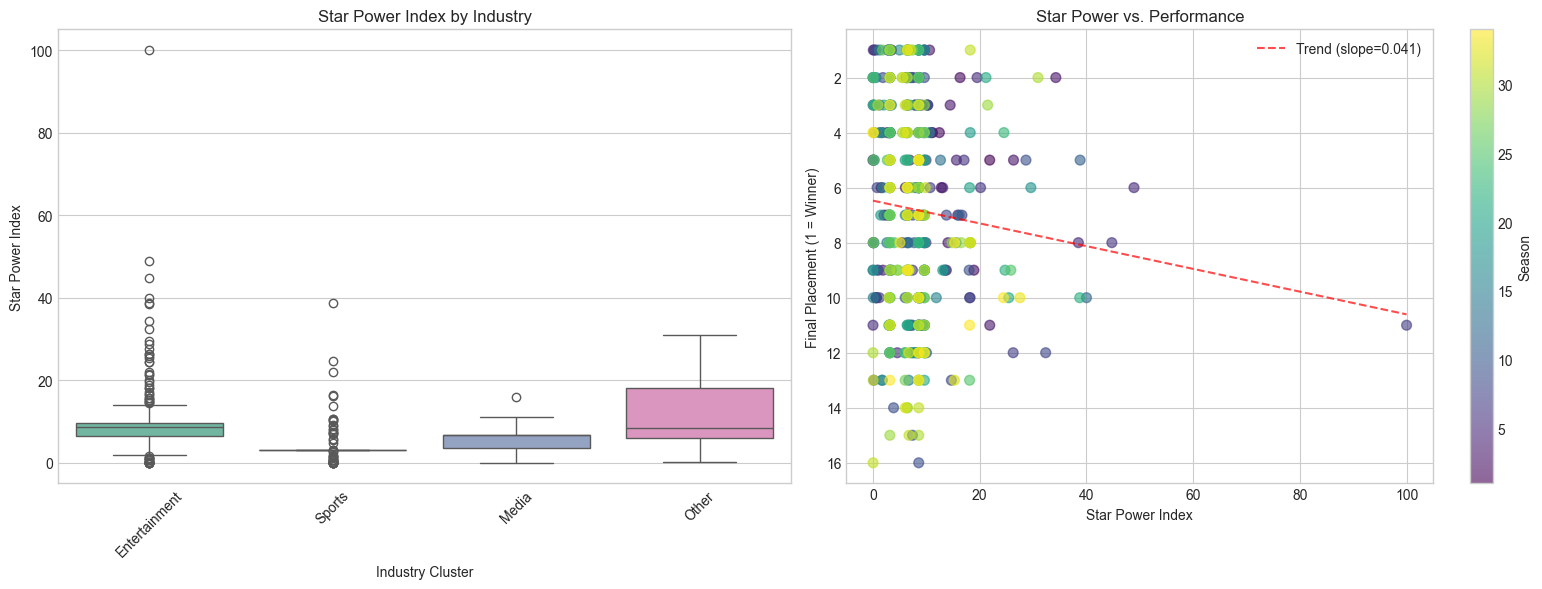

In [13]:
# Visualize Star Power Index by industry
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SPI distribution by industry cluster
ax1 = axes[0]
sns.boxplot(data=df, x='industry_cluster', y='star_power_index', ax=ax1, palette='Set2')
ax1.set_xlabel('Industry Cluster')
ax1.set_ylabel('Star Power Index')
ax1.set_title('Star Power Index by Industry')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: SPI vs Placement
ax2 = axes[1]
scatter = ax2.scatter(df['star_power_index'], df['placement'], 
                      c=df['season'], cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel('Star Power Index')
ax2.set_ylabel('Final Placement (1 = Winner)')
ax2.set_title('Star Power vs. Performance')
ax2.invert_yaxis()
plt.colorbar(scatter, ax=ax2, label='Season')

# Add trend line
z = np.polyfit(df['star_power_index'].fillna(0), df['placement'], 1)
p = np.poly1d(z)
x_line = np.linspace(0, 100, 100)
ax2.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'Trend (slope={z[0]:.3f})')
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'star_power_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. Performance Trajectory Features

In [14]:
# Calculate weekly average scores for each contestant
def get_weekly_scores(row):
    """Extract weekly average judge scores for a contestant."""
    weekly_scores = []
    for week in range(1, 12):  # Weeks 1-11
        scores = []
        for judge in range(1, 5):  # 4 judges
            col = f'week{week}_judge{judge}_score'
            if col in row.index and pd.notna(row[col]) and row[col] > 0:
                scores.append(row[col])
        if scores:
            weekly_scores.append(np.mean(scores))
        else:
            weekly_scores.append(np.nan)
    return weekly_scores

# Apply to all contestants
df['weekly_scores'] = df.apply(get_weekly_scores, axis=1)

# Calculate trajectory metrics
def calc_trajectory_metrics(scores):
    """Calculate improvement trajectory from weekly scores."""
    valid_scores = [s for s in scores if pd.notna(s) and s > 0]
    
    if len(valid_scores) < 2:
        return {'improvement_rate': np.nan, 'score_volatility': np.nan, 
                'first_week_score': valid_scores[0] if valid_scores else np.nan,
                'peak_score': np.nan, 'weeks_competed': len(valid_scores)}
    
    # Linear regression for improvement rate
    weeks = np.arange(len(valid_scores))
    slope, _ = np.polyfit(weeks, valid_scores, 1)
    
    return {
        'improvement_rate': slope,  # Points per week improvement
        'score_volatility': np.std(valid_scores),  # Consistency
        'first_week_score': valid_scores[0],
        'peak_score': max(valid_scores),
        'weeks_competed': len(valid_scores)
    }

trajectory_df = pd.DataFrame(df['weekly_scores'].apply(calc_trajectory_metrics).tolist())
df = pd.concat([df, trajectory_df], axis=1)

print("Trajectory metrics calculated:")
print(df[['celebrity_name', 'improvement_rate', 'score_volatility', 'weeks_competed']].head(10))

Trajectory metrics calculated:
      celebrity_name  improvement_rate  score_volatility  weeks_competed
0      John O'Hurley          0.333333          0.931281               6
1       Kelly Monaco          0.923810          1.682334               6
2  Evander Holyfield         -0.833333          0.720082               3
3      Rachel Hunter          0.566667          0.759203               4
4      Joey McIntyre          0.133333          0.339935               5
5      Trista Sutter          0.333333          0.166667               2
6       Tatum O'Neal         -2.000000          1.000000               2
7        Tia Carrere          0.233333          0.730297               5
8    George Hamilton          0.285714          0.628539               6
9         Lisa Rinna          0.434524          0.993745               7


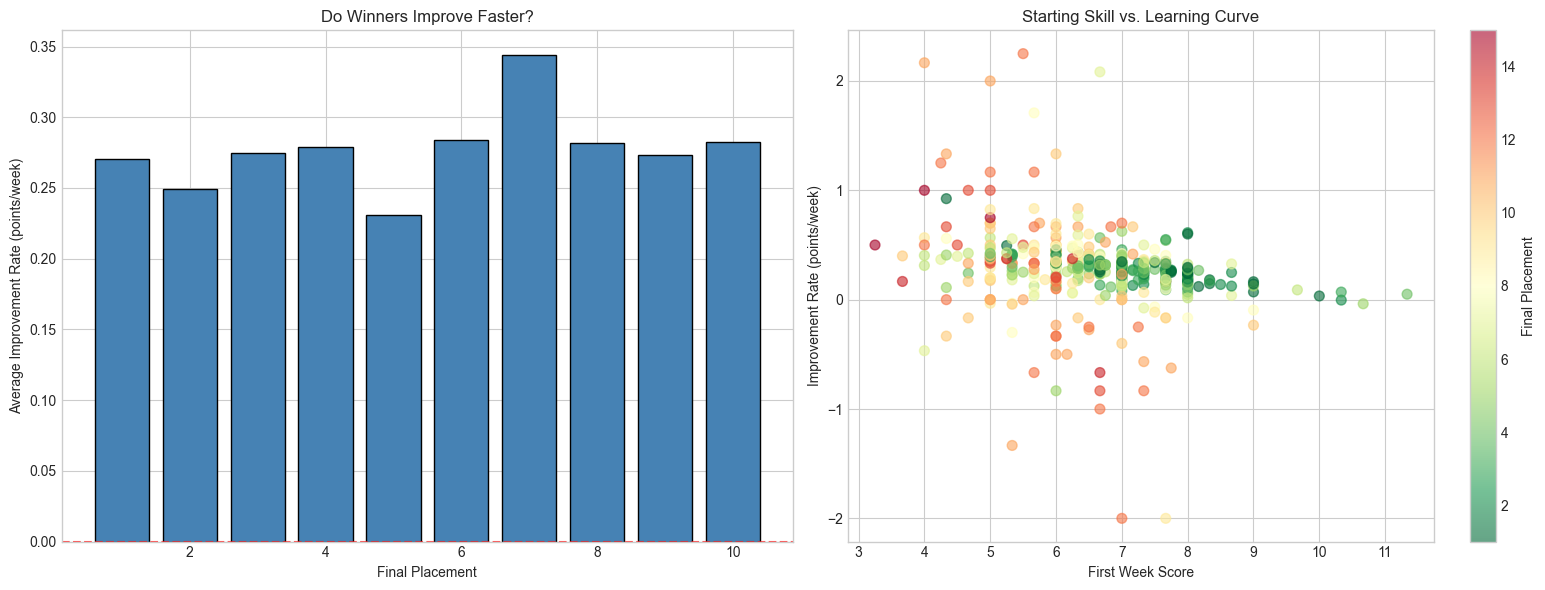

In [15]:
# Visualize improvement trajectories for winners vs non-winners
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Improvement rate by final placement
ax1 = axes[0]
placement_groups = df.groupby('placement')['improvement_rate'].mean()
ax1.bar(placement_groups.index[:10], placement_groups.values[:10], color='steelblue', edgecolor='black')
ax1.set_xlabel('Final Placement')
ax1.set_ylabel('Average Improvement Rate (points/week)')
ax1.set_title('Do Winners Improve Faster?')
ax1.axhline(0, color='red', linestyle='--', alpha=0.7)

# Plot 2: First week score vs Improvement rate
ax2 = axes[1]
scatter = ax2.scatter(df['first_week_score'], df['improvement_rate'], 
                      c=df['placement'], cmap='RdYlGn_r', alpha=0.6, s=50)
ax2.set_xlabel('First Week Score')
ax2.set_ylabel('Improvement Rate (points/week)')
ax2.set_title('Starting Skill vs. Learning Curve')
plt.colorbar(scatter, ax=ax2, label='Final Placement')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'trajectory_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 6. Final Feature Dataset

In [16]:
# Select final features for analysis
feature_cols = [
    # Identifiers
    'celebrity_name', 'ballroom_partner', 'season', 'placement',
    
    # Celebrity features
    'celebrity_age_during_season', 'age_bracket', 
    'celebrity_industry', 'industry_cluster',
    'celebrity_homestate', 'region',
    
    # Star Power
    'wiki_pageviews', 'star_power_index',
    
    # Pro dancer features
    'pro_experience', 'win_rate', 'top3_rate', 'avg_placement',
    
    # Trajectory features
    'first_week_score', 'improvement_rate', 'score_volatility', 
    'peak_score', 'weeks_competed'
]

features_df = df[feature_cols].copy()

print(f"\n📊 FINAL FEATURE DATASET")
print("="*60)
print(f"Shape: {features_df.shape}")
print(f"\nFeature summary:")
print(features_df.describe().T)


📊 FINAL FEATURE DATASET
Shape: (421, 21)

Feature summary:
                             count         mean          std        min  \
season                       421.0    18.280285     9.730038   1.000000   
placement                    421.0     6.814727     3.758656   1.000000   
celebrity_age_during_season  421.0    38.786223    13.765274  14.000000   
wiki_pageviews               184.0  1522.109035  1805.945651   1.888889   
star_power_index             414.0     8.398145     8.372346   0.000000   
pro_experience               421.0     7.197150     6.269472   0.000000   
win_rate                     421.0     0.080760     0.101097   0.000000   
top3_rate                    421.0     0.242280     0.178269   0.000000   
avg_placement                421.0     6.814727     1.747386   1.000000   
first_week_score             421.0     6.493269     1.218525   3.250000   
improvement_rate             404.0     0.276050     0.387355  -2.000000   
score_volatility             404.0     0

In [17]:
# Save features dataset
features_df.to_csv(OUTPUT_PATH / 'celebrity_features.csv', index=False)
pro_stats.to_csv(OUTPUT_PATH / 'pro_dancer_stats.csv', index=False)

# Save the wiki pageviews separately for reference
wiki_df = pd.DataFrame(list(wiki_views.items()), columns=['celebrity_name', 'wiki_pageviews'])
wiki_df.to_csv(OUTPUT_PATH / 'star_power_raw.csv', index=False)

print(f"""\n✓ FILES SAVED:
   - {OUTPUT_PATH / 'celebrity_features.csv'}
   - {OUTPUT_PATH / 'pro_dancer_stats.csv'}
   - {OUTPUT_PATH / 'star_power_raw.csv'}
   - {OUTPUT_PATH / 'star_power_analysis.png'}
   - {OUTPUT_PATH / 'trajectory_analysis.png'}

➡️ NEXT: See 12_mixed_effects_model.ipynb for regression analysis
""")


✓ FILES SAVED:
   - ../../data/obj3/celebrity_features.csv
   - ../../data/obj3/pro_dancer_stats.csv
   - ../../data/obj3/star_power_raw.csv
   - ../../data/obj3/star_power_analysis.png
   - ../../data/obj3/trajectory_analysis.png

➡️ NEXT: See 12_mixed_effects_model.ipynb for regression analysis



In [18]:
# Summary statistics
print("="*70)
print("FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"""
📊 FEATURES CREATED:

1. CELEBRITY FEATURES:
   - Age brackets: {df['age_bracket'].nunique()} categories
   - Industry clusters: {df['industry_cluster'].nunique()} categories  
   - Geographic regions: {df['region'].nunique()} categories

2. STAR POWER INDEX:
   - Source: Wikipedia pageview API (Dec 2024)
   - Coverage: {(df['wiki_pageviews'].notna().sum() / len(df) * 100):.1f}% direct hits
   - Range: 0-100 (normalized)
   - Mean SPI: {df['star_power_index'].mean():.1f}

3. PRO DANCER FEATURES:
   - Total pros: {df['ballroom_partner'].nunique()}
   - Experience range: {df['pro_experience'].min():.0f}-{df['pro_experience'].max():.0f} seasons
   - Win rate range: {pro_stats['win_rate'].min()*100:.0f}%-{pro_stats['win_rate'].max()*100:.0f}%

4. TRAJECTORY FEATURES:
   - Improvement rate: {df['improvement_rate'].mean():.3f} avg pts/week
   - Score volatility: {df['score_volatility'].mean():.2f} avg std dev
   - Correlation (improvement vs placement): {df['improvement_rate'].corr(df['placement']):.3f}
""")

FEATURE ENGINEERING SUMMARY

📊 FEATURES CREATED:

1. CELEBRITY FEATURES:
   - Age brackets: 5 categories
   - Industry clusters: 4 categories  
   - Geographic regions: 7 categories

2. STAR POWER INDEX:
   - Source: Wikipedia pageview API (Dec 2024)
   - Coverage: 43.7% direct hits
   - Range: 0-100 (normalized)
   - Mean SPI: 8.4

3. PRO DANCER FEATURES:
   - Total pros: 60
   - Experience range: 0-30 seasons
   - Win rate range: 0%-100%

4. TRAJECTORY FEATURES:
   - Improvement rate: 0.276 avg pts/week
   - Score volatility: 0.81 avg std dev
   - Correlation (improvement vs placement): 0.020

